#Project 6 - Data Engineering

Ον/μο: Μαρία Καρλάκη ΑΕΜ: 244

#Ερώτημα 1

In [1]:
!pip install ydata-profiling

Εισαγωγή των απαραίτητων βιβλιοθηκών

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

Φόρτωση του dataset

In [3]:
try:
    df = pd.read_csv('bankloan.csv')
    print("Το DataFrame φορτώθηκε επιτυχώς.")
    print(f"Διαστάσεις DataFrame: {df.shape}")
except FileNotFoundError:
    print("ΣΦΑΛΜΑ")

Το DataFrame φορτώθηκε επιτυχώς.
Διαστάσεις DataFrame: (212999, 53)


Δημιουργία αναφοράς

In [4]:
print("\nΔημιουργία αναφοράς Προφίλ... (Αυτό μπορεί να διαρκέσει λίγα λεπτά)")

profile = ProfileReport(
    df,
    title="Loan Risk Analysis Data Profile Report",
    html={'style': {'full_width': True}},
    sort=None
)

output_file = "bankloan_data_profile_report.html"
profile.to_file(output_file)

print(f"\n Η αναφορά δημιουργήθηκε επιτυχώς ως αρχείο: {output_file}")


Δημιουργία αναφοράς Προφίλ... (Αυτό μπορεί να διαρκέσει λίγα λεπτά)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 53/53 [00:13<00:00,  3.92it/s]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


 Η αναφορά δημιουργήθηκε επιτυχώς ως αρχείο: bankloan_data_profile_report.html


#Ερώτημα 2

Στατιστικά

In [5]:
try:
    df = pd.read_csv('bankloan.csv')
    mean_loan = df['loan_amnt'].mean()
    max_loan = df['loan_amnt'].max()
    min_loan = df['loan_amnt'].min()

    print("\n--- Στατιστικά Στοιχεία loan_amnt ---")
    print(f"Μέσο Ποσό (Mean): {mean_loan:,.2f} $")
    print(f"Μέγιστο Ποσό (Max): {max_loan:,.2f} $")
    print(f"Ελάχιστο Ποσό (Min): {min_loan:,.2f} $")
except FileNotFoundError:
    print("ΣΦΑΛΜΑ")
    df = None


--- Στατιστικά Στοιχεία loan_amnt ---
Μέσο Ποσό (Mean): 15,257.97 $
Μέγιστο Ποσό (Max): 35,000.00 $
Ελάχιστο Ποσό (Min): 1,000.00 $


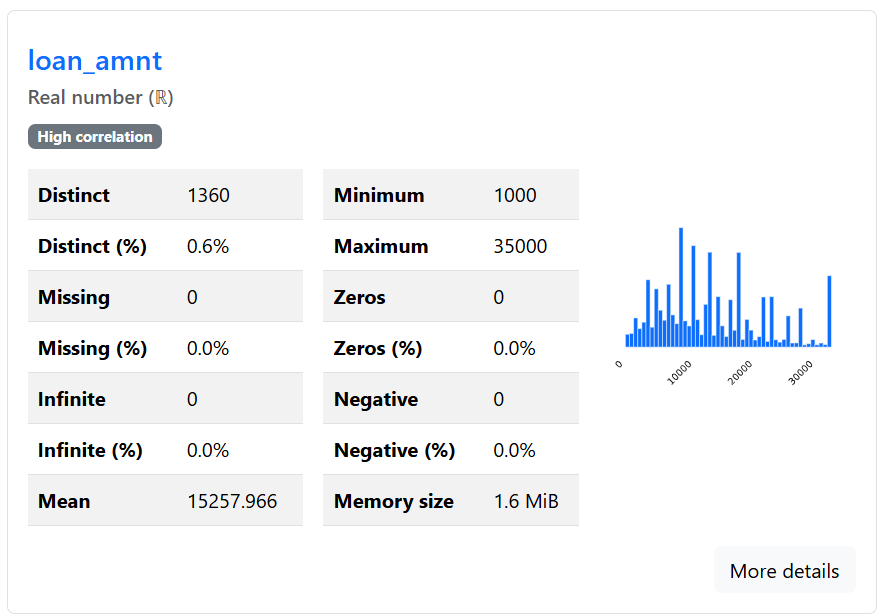

Αφαίρεση αχρείαστων μεταβλητών

In [6]:
if df is not None:
    cols_to_drop = [
        'id', 'member_id', 'funded_amnt', 'funded_amnt_inv', 'sub_grade',
        'out_prncp', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_d', 'last_pymnt_amnt', 'mths_since_last_delinq',
        'mths_since_last_record', 'next_pymnt_d'
    ]
    df_clean = df.drop(columns=cols_to_drop, errors='ignore')
    print("\n Αφαιρέθηκαν οι μη χρήσιμες μεταβλητές.")
    print(f"Νέες διαστάσεις DataFrame: {df_clean.shape}")
else:
    df_clean = None


 Αφαιρέθηκαν οι μη χρήσιμες μεταβλητές.
Νέες διαστάσεις DataFrame: (212999, 39)


Επιπλέον προεπεξεργασία

In [7]:
for col in ['int_rate', 'revol_util']:

        if col in df_clean.columns and df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.replace('%', '', regex=False).astype(float)
            print(f"Στήλη '{col}': Μετατράπηκε από String σε Float.")


for col in df_clean.select_dtypes(include=['float64', 'int64']).columns:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)


for col in df_clean.select_dtypes(include=['object']).columns:
        if df_clean[col].isnull().any():
             df_clean[col] = df_clean[col].fillna('Missing')

print(f"Νέες διαστάσεις DataFrame: {df_clean.shape}")

Νέες διαστάσεις DataFrame: (212999, 39)


υποερώτημα 4

In [8]:
if 'grade' in df_clean.columns:
    approved_grades = ['A', 'B1', 'B2']

    df_clean['target'] = df_clean['grade'].apply(lambda x: 1 if x in approved_grades else 0)

    print("\nΔημιουργήθηκε η στήλη 'target' επιτυχώς!")
    print(df_clean[['grade', 'target']].head(10))

    print("\nΚατανομή τιμών στη στήλη target:")
    print(df_clean['target'].value_counts())

else:
    print("Η στήλη 'grade' δεν βρέθηκε στο DataFrame.")


Δημιουργήθηκε η στήλη 'target' επιτυχώς!
  grade  target
0     C       0
1     C       0
2     B       0
3     B       0
4     E       0
5     C       0
6     B       0
7     D       0
8     C       0
9     E       0

Κατανομή τιμών στη στήλη target:
target
0    176127
1     36872
Name: count, dtype: int64


Υποερώτημα 5

In [9]:
if 'loan_amnt' in df_clean.columns and 'target' in df_clean.columns:

    bins = np.arange(0, df_clean['loan_amnt'].max() + 5000, 5000)
    df_clean['loan_bin'] = pd.cut(df_clean['loan_amnt'], bins=bins)

    approval_rate = (
        df_clean.groupby('loan_bin', observed=False)['target']
        .mean()
        .reset_index()
        .rename(columns={'target': 'approval_probability'})
    )

    accepted_ranges = approval_rate[approval_rate['approval_probability'] >= 0.15]

    print("\n--- Εύρη ποσού με πιθανότητα έγκρισης >= 15% ---")
    print(accepted_ranges)

    if not accepted_ranges.empty:
        best_range = accepted_ranges.sort_values('approval_probability', ascending=False).iloc[0]
        print(f"\nΕύρος με τη μεγαλύτερη πιθανότητα έγκρισης:")
        print(f"{best_range['loan_bin']} → Πιθανότητα: {best_range['approval_probability']*100:.2f}%")
    else:
        print("\nΔεν βρέθηκε εύρος ποσού με πιθανότητα ≥ 15%.")
else:
    print("Απαιτούνται οι στήλες 'loan_amnt' και 'target' για αυτό το ερώτημα.")



--- Εύρη ποσού με πιθανότητα έγκρισης >= 15% ---
         loan_bin  approval_probability
1   (5000, 10000]              0.205032
2  (10000, 15000]              0.177184
3  (15000, 20000]              0.172313
4  (20000, 25000]              0.185653
5  (25000, 30000]              0.197253

Εύρος με τη μεγαλύτερη πιθανότητα έγκρισης:
(5000, 10000] → Πιθανότητα: 20.50%


Υπάρχουν αρκετά εύρη ποσών που πληρούν το κριτήριο >= 15%, με το πλέον ευνοϊκό να είναι το 5.000 - 10.000, όπου περίπου 1 στους 5 αιτούντες λαμβάνει έγκριση δανείου. Αυτό υποδηλώνει ότι η τράπεζα προτιμά να εγκρίνει μικρότερα δάνεια, πιθανόν λόγω χαμηλότερου ρίσκου αποπληρωμής.

#Ερώτημα 3

In [10]:
if 'grade' in df_clean.columns:
    df_clean = df_clean.drop(columns=['grade'])
if 'loan_bin' in df_clean.columns:
    df_clean = df_clean.drop(columns=['loan_bin'])

X = df_clean.drop(columns=['target'])
y = df_clean['target']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols)
    ],
    sparse_threshold=1.0
)

X_scaled = preprocessor.fit_transform(X)

print("Κανονικοποιήθηκαν οι αριθμητικές τιμές και κωδικοποιήθηκαν οι κατηγορικές (χωρίς χρήση μεγάλης μνήμης).")
print(f"Διαστάσεις πίνακα X_scaled: {X_scaled.shape}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Κανονικοποιήθηκαν οι αριθμητικές τιμές και κωδικοποιήθηκαν οι κατηγορικές (χωρίς χρήση μεγάλης μνήμης).
Διαστάσεις πίνακα X_scaled: (212999, 70423)


In [11]:
for col in ['grade', 'loan_bin']:
    if col in df_clean.columns:
        df_clean = df_clean.drop(columns=[col])

X = df_clean.drop(columns=['target'])
y = df_clean['target'].astype(int)

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ],
    sparse_threshold=1.0
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

param_grid = {'clf__C': [0.5, 1.0, 2.0]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    error_score='raise'
)

print("Εκπαίδευση με CV...")
grid.fit(X_train, y_train)

print("Καλύτερη C:", grid.best_params_['clf__C'])
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print("\n--- ΑΠΟΤΕΛΕΣΜΑΤΑ (Test Set) ---")
print(f"Accuracy :  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   :  {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score :  {f1_score(y_test, y_pred, zero_division=0):.4f}")

print("\nΑναλυτική αναφορά:")
print(classification_report(y_test, y_pred, digits=4))


Εκπαίδευση με CV...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 50']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Καλύτερη C: 2.0


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 50']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



--- ΑΠΟΤΕΛΕΣΜΑΤΑ (Test Set) ---
Accuracy :  0.9613
Precision:  0.8180
Recall   :  0.9988
F1-score :  0.8994

Αναλυτική αναφορά:
              precision    recall  f1-score   support

           0     0.9997    0.9535    0.9761     52838
           1     0.8180    0.9988    0.8994     11062

    accuracy                         0.9613     63900
   macro avg     0.9089    0.9762    0.9377     63900
weighted avg     0.9683    0.9613    0.9628     63900



Για την ταξινόμηση χρησιμοποιήθηκε Logistic Regression με class_weight='balanced', solver='saga' και cross-validation για την παράμετρο C. Το καλύτερο μοντέλο (C = 2.0) πέτυχε Accuracy 96.1%, Precision 81.8%, Recall 99.9%, F1-score 89.9%. Οι μετρικές δείχνουν εξαιρετική απόδοση, με το μοντέλο να εντοπίζει σχεδόν όλους τους αξιόπιστους πελάτες (υψηλό Recall) και σχετικά λίγες λανθασμένες εγκρίσεις (ικανοποιητικό Precision).

#Ερώτημα 4


--- Random Forest (μόνο numeric features) ---
Accuracy :  0.9999
Precision:  0.9996
Recall   :  0.9998
F1-score :  0.9997

🔝 Top 15 σημαντικότερα χαρακτηριστικά:
                        Feature  Importance
0                      int_rate    0.841885
1              total_rev_hi_lim    0.041716
2                    revol_util    0.031296
3                inq_last_6mths    0.016316
4                           dti    0.014934
5                     loan_amnt    0.011734
6                   installment    0.010525
7                    annual_inc    0.008843
8                       pub_rec    0.006010
9                     revol_bal    0.004429
10                  tot_cur_bal    0.003240
11                 tot_coll_amt    0.002270
12                  delinq_2yrs    0.001730
13                  total_pymnt    0.001491
14  mths_since_last_major_derog    0.001396


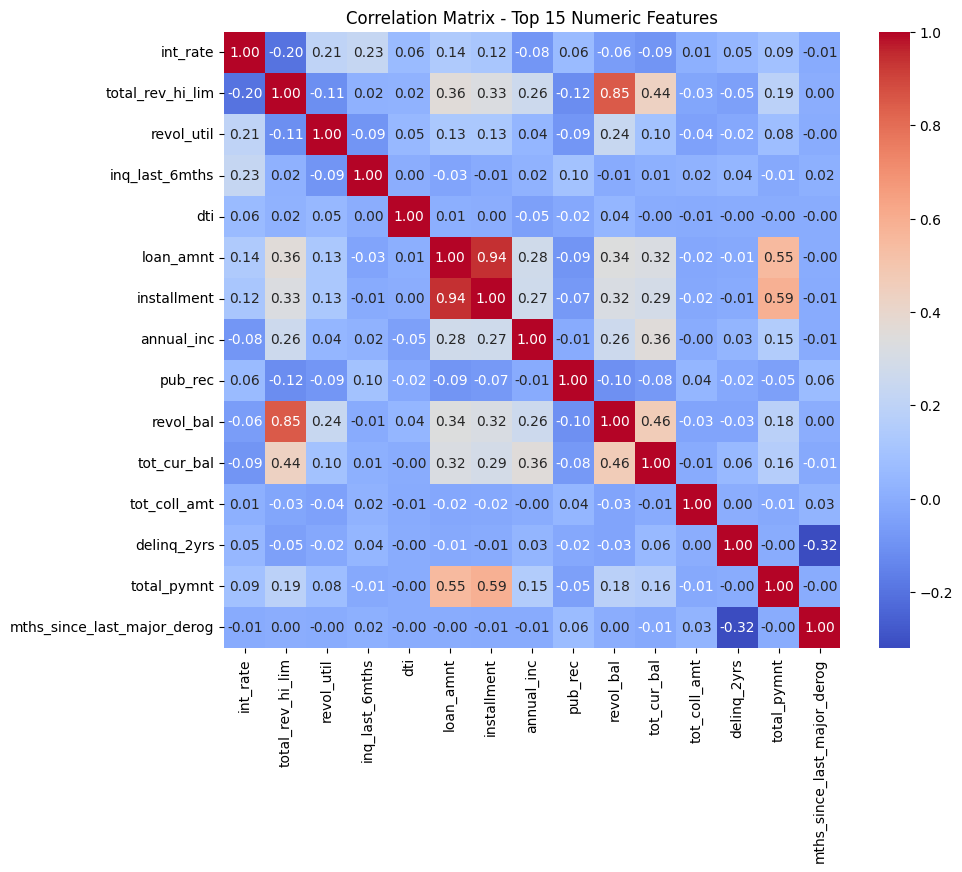


✅ Επιλεγμένα χαρακτηριστικά με χαμηλό correlation (13):
['int_rate', 'total_rev_hi_lim', 'revol_util', 'inq_last_6mths', 'dti', 'loan_amnt', 'annual_inc', 'pub_rec', 'tot_cur_bal', 'tot_coll_amt', 'delinq_2yrs', 'total_pymnt', 'mths_since_last_major_derog']

--- Random Forest με επιλεγμένα (χαμηλά correlated) χαρακτηριστικά ---
Accuracy :  0.9999
Precision:  0.9996
Recall   :  0.9998
F1-score :  0.9997


In [15]:
num_df = df_clean.select_dtypes(include=['number']).copy()

X = num_df.drop(columns=['target'], errors='ignore')
y = df_clean['target'].astype(int)

X = X.dropna(axis=1, how='all')

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\n--- Random Forest (μόνο numeric features) ---")
print(f"Accuracy :  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   :  {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score :  {f1_score(y_test, y_pred, zero_division=0):.4f}")

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

top15 = importances.head(15).reset_index(drop=True)
print("\n15 σημαντικότερα χαρακτηριστικά:")
print(top15)

corr = X[top15['Feature']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix - Top 15 Numeric Features")
plt.show()

selected = []
threshold = 0.7
for col in top15['Feature']:
    if all(abs(corr.loc[col, s]) < threshold for s in selected):
        selected.append(col)

print(f"\nΕπιλεγμένα χαρακτηριστικά με χαμηλό correlation ({len(selected)}):")
print(selected)

rf_sel = RandomForestClassifier(
    n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1
)
rf_sel.fit(X_train[selected], y_train)
y_pred_sel = rf_sel.predict(X_test[selected])

print("\n--- Random Forest με επιλεγμένα (χαμηλά correlated) χαρακτηριστικά ---")
print(f"Accuracy :  {accuracy_score(y_test, y_pred_sel):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_sel, zero_division=0):.4f}")
print(f"Recall   :  {recall_score(y_test, y_pred_sel, zero_division=0):.4f}")
print(f"F1-score :  {f1_score(y_test, y_pred_sel, zero_division=0):.4f}")

Ο Random Forest εντόπισε ως πιο σημαντικούς παράγοντες την τιμή του επιτοκίου (int_rate), τα όρια ανακυκλούμενης πίστωσης (total_rev_hi_lim), το ποσοστό χρήσης πιστωτικών ορίων (revol_util), το χρέος προς εισόδημα (dti) και το ποσό δανείου (loan_amnt). Οι περισσότερες από αυτές τις μεταβλητές παρουσιάζουν χαμηλή μεταξύ τους συσχέτιση, υποδεικνύοντας ότι συμβάλλουν ανεξάρτητα στη συνολική πρόβλεψη του κινδύνου. Μετά την αφαίρεση των πολύ συσχετισμένων χαρακτηριστικών, η επίδοση του μοντέλου παρέμεινε σχεδόν αμετάβλητη, γεγονός που δείχνει ότι η επιλογή χαρακτηριστικών μπορεί να βελτιώσει την αποδοτικότητα χωρίς απώλεια ακρίβειας.

#Ερώτημα 5

Φόρτωση του dataset MNIST...
Train=(49000, 784), Test=(21000, 784)
Εφαρμόστηκε Standard Scaling.
PCA μείωσε τις διαστάσεις σε: 300
k=5 → Accuracy = 0.9474
k=15 → Accuracy = 0.9377
k=51 → Accuracy = 0.9199
k=101 → Accuracy = 0.9074


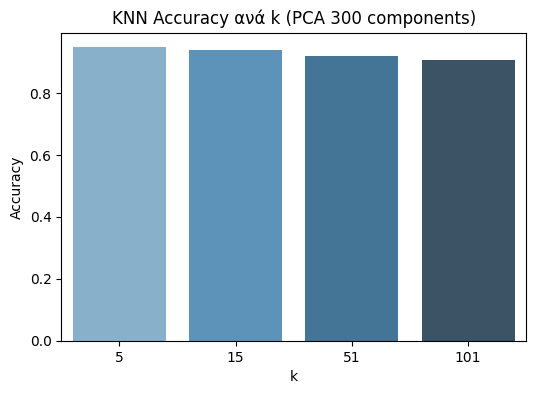

In [21]:
print("Φόρτωση του dataset MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser="pandas")
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train={X_train.shape}, Test={X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
print("Εφαρμόστηκε Standard Scaling.")

pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
print(f"PCA μείωσε τις διαστάσεις σε: {X_train_pca.shape[1]}")

k_values = [5, 15, 51, 101]
acc_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    acc_results.append((k, acc))
    print(f"k={k} → Accuracy = {acc:.4f}")

plt.figure(figsize=(6,4))
sns.barplot(
    x=[str(k) for k, _ in acc_results],
    y=[a for _, a in acc_results],
    hue=[str(k) for k, _ in acc_results],
    palette="Blues_d",
    legend=False
)
plt.title("KNN Accuracy ανά k (PCA 300 components)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()


Αν εφαρμόζαμε τη συνάρτηση fit_transform του PCA ξεχωριστά στα σύνολα x_train και x_test, τότε ο αλγόριθμος θα υπολόγιζε διαφορετικούς κύριους άξονες για κάθε σύνολο, με αποτέλεσμα τα δεδομένα του test set να προβάλλονται σε διαφορετικό χώρο από αυτόν του train, γεγονός που θα καθιστούσε την αξιολόγηση του μοντέλου μη έγκυρη. Αντίθετα, αν εφαρμόζαμε το fit_transform σε όλα τα δεδομένα μαζί (train και test), θα υπήρχε διαρροή πληροφορίας (data leakage) από το test set προς το train, αφού οι άξονες του PCA θα υπολογίζονταν γνωρίζοντας ήδη τη συνολική κατανομή των δεδομένων. Για τον λόγο αυτό, εφαρμόζουμε fit_transform μόνο στο train set και transform στο test set, ώστε και τα δύο να προβάλλονται στο ίδιο χώρο χαρακτηριστικών χωρίς διαρροή πληροφορίας.

LDA

NaN σε LDA train: 0
Ελάχιστο/Μέγιστο LDA1: -6.985179786579566 7.9406324563156065
Ελάχιστο/Μέγιστο LDA2: -7.153849422231066 6.860406090568259


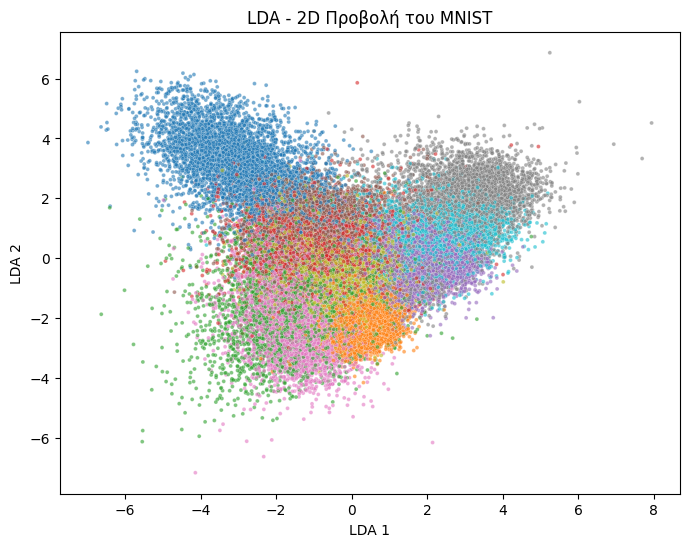

In [29]:
pca_for_lda = PCA(n_components=50, svd_solver='randomized', random_state=42)
X_train_pca_lda = pca_for_lda.fit_transform(X_train_scaled)
X_test_pca_lda  = pca_for_lda.transform(X_test_scaled)

lda = LDA(n_components=2, solver='eigen', shrinkage='auto')
X_train_lda = lda.fit_transform(X_train_pca_lda, y_train.values)
X_test_lda  = lda.transform(X_test_pca_lda)

if isinstance(X_train_lda, pd.DataFrame):
    Xtl = X_train_lda.to_numpy()
else:
    Xtl = np.asarray(X_train_lda)

print("NaN σε LDA train:", np.isnan(Xtl).sum())
print("Ελάχιστο/Μέγιστο LDA1:", float(np.nanmin(Xtl[:, 0])), float(np.nanmax(Xtl[:, 0])))
print("Ελάχιστο/Μέγιστο LDA2:", float(np.nanmin(Xtl[:, 1])), float(np.nanmax(Xtl[:, 1])))

if isinstance(X_train_lda, pd.DataFrame):
    lda_df = X_train_lda.copy()
    lda_df.columns = ['LDA1', 'LDA2']
else:
    lda_df = pd.DataFrame(Xtl, columns=['LDA1', 'LDA2'])

lda_df['label'] = y_train.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=lda_df, x='LDA1', y='LDA2',
    hue='label', palette='tab10', s=8, alpha=0.6, legend=False
)
plt.title("LDA - 2D Προβολή του MNIST")
plt.xlabel("LDA 1"); plt.ylabel("LDA 2")
plt.show()





U MAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


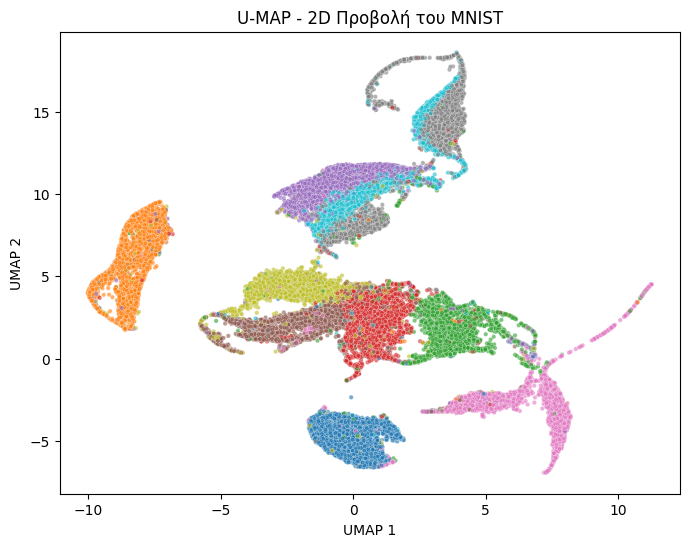

In [30]:
!pip install umap-learn -q
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_scaled)

umap_df = pd.DataFrame(X_train_umap, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = y_train.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df, x='UMAP1', y='UMAP2',
    hue='label', palette='tab10', s=10, alpha=0.6, legend=False
)
plt.title("U-MAP - 2D Προβολή του MNIST")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

Η μέθοδος LDA (Linear Discriminant Analysis) δημιουργεί έναν γραμμικό χώρο που προσπαθεί να μεγιστοποιήσει τον διαχωρισμό μεταξύ των κλάσεων. Όπως φαίνεται στο πρώτο γράφημα, τα ψηφία σχηματίζουν μερικώς διακριτά clusters, αλλά υπάρχει σημαντική επικάλυψη μεταξύ παρόμοιων ψηφίων. Αυτό οφείλεται στο ότι η LDA χρησιμοποιεί γραμμικούς άξονες και μπορεί να σχηματίσει έως C-1 διαστάσεις, οπότε η μείωση σε 2D αναγκαστικά χάνει πληροφορία. Αντίθετα η UMAP (Uniform Manifold Approximation and Projection) είναι μη γραμμική μέθοδος που αναπαριστά καλύτερα την τοπολογία των δεδομένων. Στο δεύτερο γράφημα, τα ψηφία διαχωρίζονται σε καθαρά clusters με πολύ μικρότερη επικάλυψη. Έτσι η UMAP αποτυπώνει πιο φυσικά τη γεωμετρική δομή και τις αποστάσεις των ψηφίων στο χώρο.